<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/1006.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DBSCAN from scratch

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

sns.set_theme()

## Create the dataset

<Axes: xlabel='dim1', ylabel='dim2'>

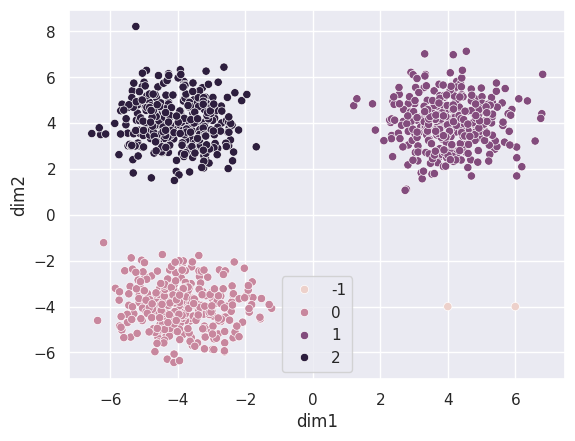

In [2]:
# Create dataset
X, y = make_blobs(n_samples=1000, n_features=2, random_state=4, centers=[[-4,-4], [4,4], [-4,4]])

# Add two outliers
X = np.vstack([X, np.array([[4,-4], [6,-4]])])
y = np.concatenate([y, np.array([-1,-1])])

# Convert to data frame
X_df = pd.DataFrame(X, columns=['dim1', 'dim2'])

# Plot the blobs
sns.scatterplot(X_df, x='dim1', y='dim2', hue=y)

### Radius neighbors

In [3]:
nearest_neigh = NearestNeighbors()
nearest_neigh = nearest_neigh.fit(X)

In [4]:
example_data_point_id = 0
# the radius and neighbors method requires two dimensional array as input
# where rows are samples and columns are features
np.expand_dims(X[example_data_point_id], axis=0)

array([[-3.61771896, -3.59530662]])

In [5]:
nearest_neigh.radius_neighbors(
    np.expand_dims(X[example_data_point_id], axis=0),
    radius=0.2,
    return_distance=True
)
#  the data point (id 0 in this case) is considered its own neighbor

(array([array([0.18238293, 0.15527816, 0.16316669, 0.14078337, 0.16469154,
               0.        , 0.08413493, 0.12522063])                       ],
       dtype=object),
 array([array([ 15, 180, 113, 345, 136,   0, 742, 839])], dtype=object))

In [6]:
nearest_neigh.radius_neighbors(
    X[[0,1], :],
    radius=0.2,
    return_distance=False
)

array([array([ 15, 180, 113, 345, 136,   0, 742, 839]),
       array([280,  33,   1, 926, 973, 998, 391])], dtype=object)

### DBSCAN

In [7]:
# Set main parameters
eps = 1
min_samples = 5

In [8]:
# Create dataframe to store results
point_df = pd.DataFrame(index=X_df.index)

point_df['cluster'] = None
point_df['unvisited'] = True
point_df['core'] = False
point_df['border'] = False

point_df.head()
# each row corresponds to a single data point
# we will beusing this data frame in order to store information on whether a data point is a border point,
# or whether it is a core point or whether it is unvisited
# we will also use this data frame in order to store information on a cluster identity

,cluster,unvisited,core,border
0,None,True,False,False
1,None,True,False,False
2,None,True,False,False
3,None,True,False,False
4,None,True,False,False


In [9]:
# Id of first cluster is 0
current_cluster = 0

# Outter loop iterates through clusters
while True:
    # Check if there are unvisited points left
    if point_df['unvisited'].sum()==0:
        break

    # Get first (or maybe random) available unvisited point
    curr_point = point_df[point_df['unvisited']].index[0]

    # Get neighbors of selected point within eps radius
    # cluster_points set will be used to add cluster candidates
    cluster_points = set(
        nearest_neigh.radius_neighbors(
            np.expand_dims(X[curr_point], axis=0),
            radius=eps,
            return_distance=False
            )[0]
        )

    # If point has enough neighbors within eps radius
    # then start building the cluster
    if len(cluster_points) >= min_samples: # core data point
        # Assign cluster id to the current data point
        point_df.loc[curr_point, 'cluster'] = current_cluster
        point_df.loc[curr_point, 'core'] = True

        # queue
        cluster_points = {point for point in cluster_points if point_df.loc[point, 'unvisited']}

        # Cluster is built in this loop
        while True:

            # Select one of the candiate points
            curr_point = cluster_points.pop()

            point_df.loc[curr_point, 'unvisited'] = False
            point_df.loc[curr_point, 'cluster'] = current_cluster

            # Get all neighbors of curr_point that are within eps distance
            curr_cluster_points = set(
                nearest_neigh.radius_neighbors(
                    np.expand_dims(X[curr_point], axis=0),
                    radius=eps,
                    return_distance=False
                    )[0]
                )

            # If number of obtained neighbors is not sufficient
            # then data point is border data point
            if len(curr_cluster_points) < min_samples:
                point_df.loc[curr_point, 'border'] = True
            # If point has sufficient neighborhood:
            else:
                point_df.loc[curr_point, 'core'] = True

                # Add point to the current cluster
                # Get all of the point neighbors within eps distance
                add_points = {point for point in curr_cluster_points if point_df.loc[point, 'unvisited']}

                # Add neighbors to the current cluster candidates
                cluster_points.update(add_points)

            # If no cluster candidates remain, then
            # break the loop and proceed to the next
            # cluster
            if len(cluster_points) == 0:
                break

        # Incremen cluster ID
        current_cluster+=1
    else:
        # If selected point does not have sufficient
        # neighborhood then mark it as visited and continue
        point_df.loc[curr_point, 'unvisited'] = False

In [10]:
# Find all points without assigned cluster
remaining_points = point_df[point_df['cluster'].isna()].index.to_list()
core_points = point_df[point_df['core'] == True].index.to_list()

# Iterate through all the points
for curr_point in remaining_points:
    # Find all neighbors within eps radius
    neighbours = nearest_neigh.radius_neighbors(
        np.expand_dims(X[curr_point], axis=0),
        radius=eps,
        return_distance=False
    )[0]

    # If data point has no neighbors, declare it as noise.
    if neighbours.shape[0] == 1:
        point_df.loc[curr_point, 'cluster'] = -1 # outlier
    # Otherwise, check if there are core data points
    # in the current data point neighbourhood
    else:
        for neighbour in neighbours:
            if neighbour in core_points:
                point_df.loc[curr_point, 'cluster'] = point_df.loc[neighbour, 'cluster']
                point_df.loc[curr_point, 'border'] = True
                break

        if point_df.loc[curr_point, 'cluster'] is None:
            point_df.loc[curr_point, 'cluster'] = -1

<Axes: xlabel='dim1', ylabel='dim2'>

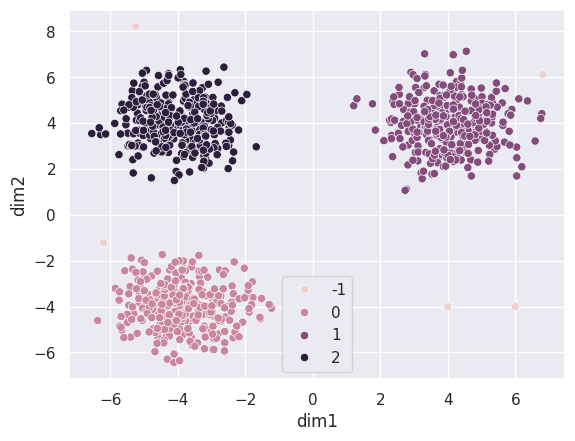

In [11]:
# Plot clustering
sns.scatterplot(X_df, x='dim1', y='dim2', hue=point_df['cluster'].to_numpy())